In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()
import sklearn
from __future__ import print_function
from IPython.display import Image
from IPython.display import display
from IPython.display import HTML
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing



In [2]:
dt1 = pd.read_csv("911.csv")



In [3]:
dt1 = dt1[dt1['timeStamp'].str.contains('2016', na = False)]
dt2 = dt1.drop(["desc","addr","e"],axis=1)

In [4]:
dt3 = dt2.drop(["zip","twp"],axis=1)



In [5]:
outliers = dt3.loc[((dt3['lat'] < 39.00) | (dt3['lat'] > 41.00)) & 
                   ((dt3['lng'] < -77.00) | (dt3['lng'] > -74.00))]

In [6]:
dt4 = dt3.loc[((dt3['lat'] > 39.00) & (dt3['lat'] < 41.00)) & 
              ((dt3['lng'] > -77.00) & (dt3['lng'] < -74.00))]

In [7]:
# we want to get event type from its title
# first we list unique values in title
titles_unique = pd.DataFrame(dt4.title.unique())
titles_unique = titles_unique.sort_values([0],ascending =  True)
print ("Unique titles size :",len(titles_unique))
titles_unique.head(5)

Unique titles size : 119


,0
2,EMS: ABDOMINAL PAINS
99,EMS: ACTIVE SHOOTER
43,EMS: ALLERGIC REACTION
3,EMS: ALTERED MENTAL STATUS
73,EMS: AMPUTATION


In [8]:
dt5 = dt4.copy()
dt5['category'],dt5['category2'] = dt5['title'].str.split(':',1).str
dt5 = dt5.drop(['title','category2'],axis = 1)
cat_unique = pd.DataFrame(dt5.category.unique())
cat_unique = cat_unique.sort_values([0],ascending =  True)
cat_unique.head()

,0
0,EMS
1,Fire
2,Traffic


In [9]:
CATEGORIES = {'EMS':0,'Fire':1,'Traffic':2}
dt5['category'].replace(CATEGORIES,inplace=True)
dt5.head(3)

,lat,lng,timeStamp,category
7916,40.121354,-75.363829,2016-01-01 00:10:08,0
7917,40.140505,-75.310874,2016-01-01 00:14:45,0
7918,40.246837,-75.681381,2016-01-01 00:20:43,0


In [10]:
hours_range = 3
dt6 = dt5
dt6['datetime'] = pd.to_datetime(dt5['timeStamp'])
dt6['year'] = dt5['datetime'].dt.year
dt6['month'] = dt5['datetime'].dt.month
dt6['day'] = dt5['datetime'].dt.day
dt6['part_of_the_day'] = np.floor(dt5['datetime'].dt.hour/hours_range)
dt6['part_of_the_day'] = dt5.part_of_the_day.astype(int)
dt6['dayofweek'] = dt5['datetime'].dt.dayofweek
dt6['week'] = dt5['datetime'].dt.week
#let's describe the dat again
dt6.describe()

,lat,lng,category,year,month,day,part_of_the_day,dayofweek,week
count,142352.000000,142352.000000,142352.000000,142352.0,142352.000000,142352.000000,142352.000000,142352.000000,142352.000000
mean,40.159112,-75.316563,0.863212,2016.0,6.534956,15.912105,4.019353,2.908551,26.685407
std,0.085606,0.151713,0.910901,0.0,3.485908,8.769763,1.880139,1.953423,15.239628
min,39.952584,-75.729789,0.000000,2016.0,1.000000,1.000000,0.000000,0.000000,1.000000
25%,40.099784,-75.391998,0.000000,2016.0,4.000000,8.000000,3.000000,1.000000,13.000000
50%,40.144662,-75.304587,1.000000,2016.0,7.000000,16.000000,4.000000,3.000000,27.000000
75%,40.229008,-75.211735,2.000000,2016.0,10.000000,23.000000,5.000000,5.000000,40.000000
max,40.479853,-74.993076,2.000000,2016.0,12.000000,31.000000,7.000000,6.000000,53.000000


In [11]:
epsilon = 0.0001
lat_max = dt6['lat'].max() + epsilon
lat_min = dt6['lat'].min()
lat_range = lat_max - lat_min
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)
lng_max = dt6['lng'].max() + epsilon
lng_min = dt6['lng'].min()
lng_range = lng_max - lng_min
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)

Latitude min-max: < 39.9525839 40.479953200000004 > | range : 0.5273693000000037
Longitude min-max: < -75.7297893 -74.9929755 > | range : 0.7368137999999931


In [12]:
lat_split = 5 # number of horizontal parts
lng_split = 7 # number of vertical parts
lat_hop = lat_range/lat_split # lat divided to N parts gives us length of one part
print ("Lat hop : ",lat_hop)
lng_hop = lng_range/lng_split # lng divided to N parts gives us length of one part
print ("Lng hop : ",lng_hop)
# now we need to assign coordinates to proper geogrid squares
dt6['lat_grid'] = (np.floor(((dt6['lat']-lat_min)/lat_hop)))
dt6['lng_grid'] = (np.floor(((dt6['lng']-lng_min)/lng_hop)))
dt6.lat_grid = dt6.lat_grid.astype(int)
dt6.lng_grid = dt6.lng_grid.astype(int)
dt7 = dt6.drop(['lat','lng'],axis = 1)
dt7 = dt6


Lat hop :  0.10547386000000074
Lng hop :  0.1052591142857133


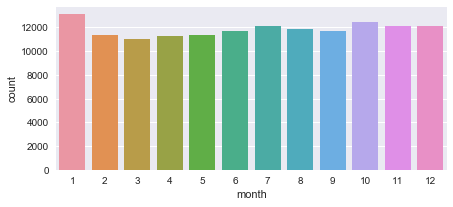

In [13]:
fig, ax = plt.subplots(figsize=(7,3))  
ax = sns.countplot(x="month", data=dt7,ax=ax)

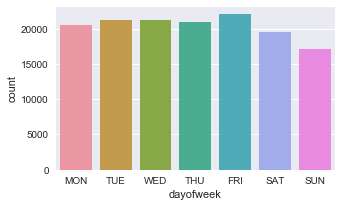

In [14]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x="dayofweek", data=dt7)
ax.axes.set_xticklabels(["MON", "TUE","WED","THU","FRI","SAT","SUN"])
pass

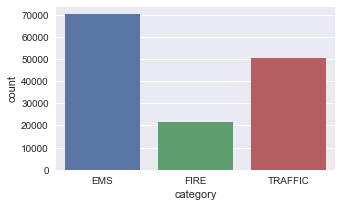

In [15]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x="category", data=dt7)
ax.axes.set_xticklabels(["EMS","FIRE","TRAFFIC"])
pass

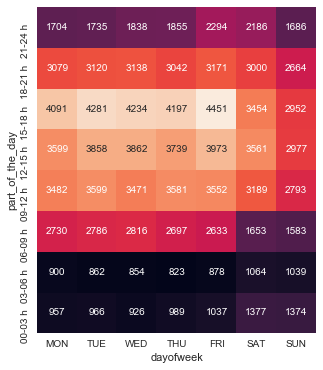

In [16]:
dt_timegrid = dt7.groupby(['dayofweek','part_of_the_day']).size().reset_index(name='count')
dt_timeheatmap = dt_timegrid.pivot(index='part_of_the_day', columns='dayofweek', values='count')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,6))
ax = sns.heatmap(dt_timeheatmap,annot=True, fmt="d",cbar=False)
ax.invert_yaxis()
ax.axes.set_yticklabels(["00-03 h","03-06 h","06-09 h","09-12 h","12-15 h","15-18 h","18-21 h","21-24 h"])
ax.axes.set_xticklabels(["MON", "TUE","WED","THU","FRI","SAT","SUN"])
pass

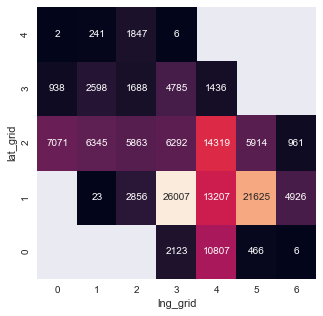

Longitude min-max: < -75.7297893 -74.9929755 > | range : 0.7368137999999931
Latitude min-max: < 39.9525839 40.479953200000004 > | range : 0.5273693000000037


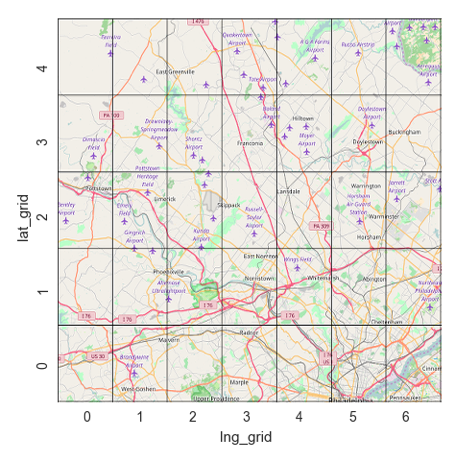

In [17]:

# now we can visualize our data on the geogrid.
dt_geogrid = dt7.groupby(['lat_grid','lng_grid']).size().reset_index(name='count')
dt_geoheatmap = dt_geogrid.pivot(index='lat_grid',columns='lng_grid', values='count')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(dt_geoheatmap,annot=True,fmt=".0f",cbar=False)
ax.invert_yaxis()
plt.show()
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)

img = Image(filename = "montco-map-grid.png", width=480, height=480)
display(img)


In [18]:
final_columns = ["month","week","dayofweek","day","part_of_the_day","lat_grid","lng_grid","category"]
dt7 = dt6[final_columns]


In [19]:
groupby_list = ['month','week','dayofweek','day','part_of_the_day','lat_grid','lng_grid']
dt_cat = dict() # holder for subdatasets with categories. 
for item in CATEGORIES:
    dt_temp = dt7.loc[(dt7['category'] == CATEGORIES[item])]
    dt_cat[item] =  dt_temp.groupby(groupby_list).size().reset_index(name='count')
dt_cat['ALL'] = dt7.groupby(groupby_list).size().reset_index(name='count') # All data, without category grouping
dt_cat['ALL'].head(3)

,month,week,dayofweek,day,part_of_the_day,lat_grid,lng_grid,count
0,1,1,0,4,0,0,5,1
1,1,1,0,4,0,1,3,12
2,1,1,0,4,0,1,4,2


In [20]:

def run_regression(name,input_dt):
    X = input_dt.iloc[:,[0,1,2,3,4,5,6]]
    Y = input_dt.iloc[:,[7]]
    Y = Y.values.reshape(len(X))
    validation_size = 0.20
    seed = 7
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = validation_size,random_state = seed)
    model = GradientBoostingRegressor(n_estimators=200, 
                                      learning_rate=0.2, max_depth=5, random_state=0, loss='ls', warm_start =  True)
    model.fit(X_train,Y_train)
    return name,model,r2_score(Y_test, model.predict(X_test))

results_table = [["CATEGORY","R2 SCORE"]]
trained_models = dict() # holder for trained models
for item in dt_cat:
    results = run_regression(item,dt_cat[item])
    results_table.append([item,results[2]])
    trained_models[item] =  results[1]

print (results_table)

[['CATEGORY', 'R2 SCORE'], ['EMS', 0.4976920954341245], ['Fire', 0.1462325520088681], ['Traffic', 0.3778691772030486], ['ALL', 0.6099150737723225]]


In [21]:
singleday_dt = []
# record structure is month,week,dayofweek,day,day_part,lat_grid,lng_grid
row_base = [1,3,4,6] 
for day_idx in range(24//hours_range):
    for idx,row in dt_geogrid.iterrows():
        singleday_dt.append(row_base+[day_idx,row['lat_grid'],row['lng_grid']]) 
singleday_dt = pd.DataFrame(singleday_dt,columns=final_columns[:7])

In [22]:
predictions_all = trained_models['ALL'].predict(singleday_dt)
singleday_dt_full = singleday_dt
singleday_dt_full['events'] = predictions_all


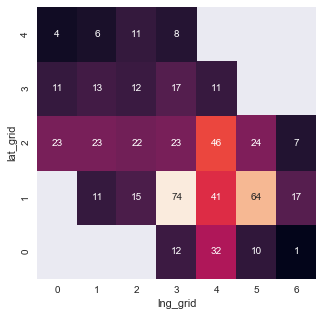

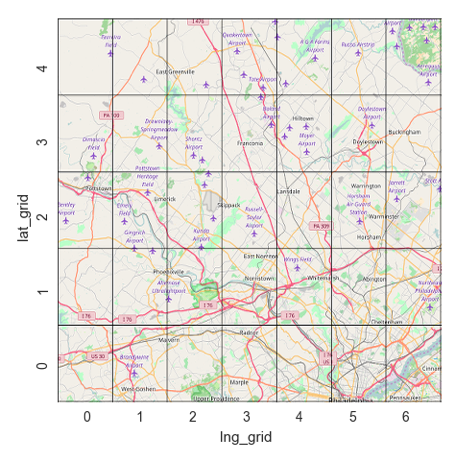

In [23]:

dt_geogrid = singleday_dt_full.groupby(['lat_grid','lng_grid']).agg({'events': np.sum}).reset_index()
dt_geoheatmap = dt_geogrid.pivot(index='lat_grid', columns='lng_grid', values='events')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(dt_geoheatmap,annot=True,fmt=".0f",cbar=False)
ax.invert_yaxis()
plt.show()
fig = ax.get_figure()
fig.savefig("6.png")
img = Image(filename = "montco-map-grid.png", width=480, height=680)
display(img)

In [24]:
data_timeevents = singleday_dt_full.groupby(['part_of_the_day']).agg({'events': np.sum}).reset_index()
print(data_timeevents)


   part_of_the_day     events
0                0  33.671661
1                1  32.216142
2                2  71.670617
3                3  83.181702
4                4  92.191266
5                5  92.302918
6                6  75.830827
7                7  58.826057
